In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from tqdm import tqdm
from sklearn import preprocessing

In [4]:
df_train_iden = pd.read_csv('../input/train_identity.csv',index_col='TransactionID')
df_train_trans = pd.read_csv('../input/train_transaction.csv',index_col='TransactionID')
df_test_iden = pd.read_csv('../input/test_identity.csv',index_col='TransactionID')
df_test_trans = pd.read_csv('../input/test_transaction.csv',index_col='TransactionID')

df_train = pd.merge(df_train_trans, df_train_iden, on='TransactionID', how='left')
df_test = pd.merge(df_test_trans, df_test_iden, on='TransactionID', how='left')

In [5]:
df_train_DT = pd.read_csv('../src/make_data/data/005_train.csv',index_col='TransactionID')

In [12]:
col_list = list(df_train.columns)

In [13]:
col_list

['isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67

(array([72700., 62448., 33070., 32968., 70338., 51717., 27567., 72752.,
        65106., 92941.]),
 array([100., 150., 200., 250., 300., 350., 400., 450., 500., 550., 600.]),
 <a list of 10 Patch objects>)

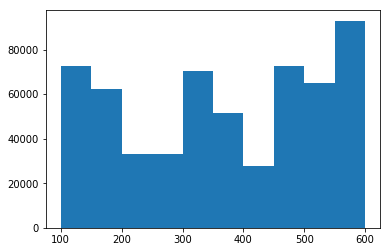

In [36]:
plt.hist(df_train['card2'])

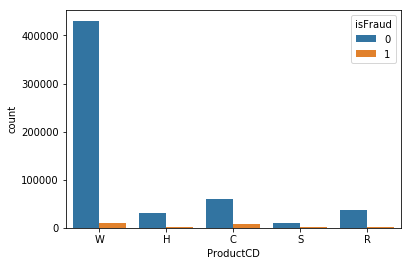

In [38]:
# sns.countplot(y='isFraud', x="ProductCD", data=df_train)
sns.countplot(x="ProductCD",hue = "isFraud", data=df_train)

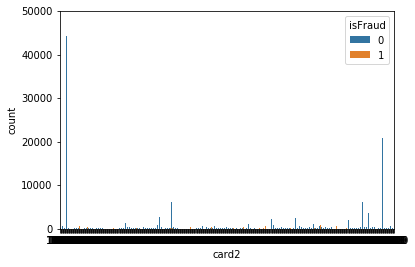

In [39]:
sns.countplot(x="card2",hue = "isFraud", data=df_train)

In [64]:
for card2 in df_train['card2'].unique():
    num_0 = len(df_train[(df_train['isFraud'] == 0) & (df_train['card2'] == card2)])
    num_1 = len(df_train[(df_train['isFraud'] == 1) & (df_train['card2'] == card2)])
    if num_0 == 0:
        num_0 = 0.01
    isf_per = num_1/num_0
    if isf_per > 0.5:
        print(card2)

176.0
405.0
289.0
319.0


In [68]:
card2 = [176,405,289,319]
num_0 = len(df_train[(df_train['isFraud'] == 0) & (df_train['card2'] == card2)])
num_1 = len(df_train[(df_train['isFraud'] == 1) & (df_train['card2'] == card2)])
print(num_0,num_1)

61 39


In [76]:
for card2 in df_train['card2'].unique():
    num_0 = len(df_train[(df_train['isFraud'] == 0) & (df_train['card2'] == card2)])
    num_1 = len(df_train[(df_train['isFraud'] == 1) & (df_train['card2'] == card2)])
#     isf_per = num_1/num_0
    if num_1 == 0:
        print(card2)
        print()

nan
352.0
243.0
423.0
446.0
535.0
117.0
147.0
388.0
309.0
101.0
191.0
313.0
432.0
251.0
135.0
260.0
136.0
106.0
503.0
468.0
370.0
150.0
458.0
509.0
258.0
356.0
105.0
171.0
559.0
286.0
133.0
162.0
163.0
551.0
472.0
102.0
389.0
589.0
281.0
339.0
280.0
510.0
593.0
262.0
571.0
394.0
166.0
304.0
485.0
376.0
461.0
582.0
499.0
287.0
519.0
424.0
183.0
516.0
342.0
112.0
278.0
229.0
234.0
291.0
596.0
539.0
126.0
568.0
146.0
290.0
240.0
201.0
222.0
248.0
450.0
192.0
255.0
330.0
574.0
200.0
219.0
337.0
317.0
433.0
552.0
563.0
306.0
193.0
540.0
109.0
386.0
471.0
208.0
524.0
132.0
182.0
434.0
220.0
282.0
173.0
402.0
305.0
427.0
196.0
149.0
531.0
493.0
412.0
473.0
153.0
190.0
465.0
235.0
598.0
151.0
217.0
139.0
259.0
189.0
263.0
188.0
508.0
233.0
344.0
328.0
323.0
213.0
377.0
521.0
288.0
241.0
456.0
227.0
121.0
230.0
466.0
425.0
506.0
335.0
597.0
469.0
486.0
401.0
421.0
124.0
195.0
129.0
363.0
292.0
175.0
430.0
331.0
329.0
483.0
457.0
518.0
538.0
261.0
419.0
397.0
137.0
378.0
451.0
293.0
120.0
326.0
